In [ ]:
import pandas as pd

# Load dataset yang sudah di preprocess
dataset = pd.read_csv('data/preprocessed_dataset.csv')
dataset.head()


In [ ]:
# Menghitung jumlah token dalam sampel dari kolom 'stemmed'
sample_stemmed = dataset['stemmed'].sample(1).values[0]
count_tokens = len(sample_stemmed)

print(f"Jumlah token dalam sampel: {count_tokens}")

In [ ]:
# Print sampel untuk verifikasi
print(f"Sampel teks: {sample_stemmed}")

In [ ]:
import ast

def parse_tokens(cell):
    # Jika sudah list, tidak perlu parse
    if isinstance(cell, list):
        return cell
    try:
        return ast.literal_eval(cell)  # Konversi dari string ke list
    except Exception:
        return []

clean_corpus = dataset['stemmed'].apply(parse_tokens).tolist()


In [ ]:
# Verifikasi hasil konversi
print(f"Jumlah dokumen dalam clean_corpus: {len(clean_corpus)}")
print(clean_corpus[0])
print(type(clean_corpus[0]))  # Harusnya: <class 'list'>

In [ ]:
from gensim.models import Word2Vec
import multiprocessing

# Fungsi untuk membuat model Word2Vec yang dioptimalkan
def create_optimized_word2vec(clean_corpus):
    # Gunakan semua CPU cores yang tersedia
    cores = multiprocessing.cpu_count()
    
    model = Word2Vec(
        sentences=clean_corpus,   # Input corpus yang sudah dibersihkan
        vector_size=300,          # Optimal untuk dataset menengah
        window=8,                 # Lebih besar untuk konteks yang lebih kaya
        min_count=1,              # Filter kata yang jarang muncul
        workers=cores,            # Gunakan semua CPU cores
        sg=0,                     # CBOW lebih efisien untuk dataset besar
        epochs=15,                # Lebih banyak iterasi untuk konvergensi yang baik
        alpha=0.03,               # Learning rate awal yang sedikit lebih tinggi
        min_alpha=0.0001,         # Learning rate minimum
        negative=10,              # Negative sampling untuk efisiensi
        sample=1e-4,              # Subsampling untuk kata frekuensi tinggi
        seed=42,                  # Reproducibility
        compute_loss=True         # Monitor training loss
    )
    
    return model

# Membuat model Word2Vec yang dioptimalkan
optimized_model = create_optimized_word2vec(clean_corpus)

# Menyimpan model Word2Vec yang telah dioptimalkan
optimized_model.save('models/optimized_word2vec.model')

In [1]:
from gensim.models import Word2Vec

# Load model untuk verifikasi
loaded_model = Word2Vec.load('models/optimized_word2vec.model')

In [2]:
print(f"Ukuran vocab: {len(loaded_model.wv)}")
print("Contoh kata dalam vocab:", list(loaded_model.wv.key_to_index.keys())[:10])


Ukuran vocab: 91064
Contoh kata dalam vocab: ['jakarta', 'partai', 'presiden', 'indonesia', 'calon', 'jokowi', 'ketua', 'pilih', 'menteri', 'pilkada']


In [3]:
# Menguji model dengan mengambil vektor untuk kata tertentu
test_word = 'virus'

if test_word in loaded_model.wv:
    vector = loaded_model.wv[test_word]
    print(f"Vektor untuk '{test_word}': {vector}")
else:
    print(f"Kata '{test_word}' tidak ditemukan dalam model.")

Vektor untuk 'virus': [-1.03142583e+00 -1.12350678e+00 -1.48219001e+00  1.20174468e+00
  2.43135834e+00  4.85138625e-01 -2.65611440e-01 -9.72762406e-01
 -3.35541308e-01  6.69821680e-01 -6.35344148e-01 -6.40469015e-01
  2.41969481e-01  3.87453973e-01  9.43792880e-01  7.79622793e-01
  8.23401630e-01  2.92007208e-01  4.02175069e-01 -1.45694876e+00
  1.20760095e+00  2.33527184e+00  2.09865379e+00 -5.53066075e-01
 -8.67106080e-01 -3.49091381e-01  7.28457570e-02 -9.45187390e-01
  1.28190041e+00  1.59475887e+00  2.30225730e+00 -4.62229326e-02
  2.79215366e-01  4.33996886e-01 -9.32592690e-01 -1.78144658e+00
  1.36819363e+00 -1.63981092e+00  3.06238055e+00 -1.97253764e+00
 -8.72550130e-01  3.90087426e-01  6.31598663e-03  3.74804176e-02
 -9.89756703e-01  4.49730605e-02  8.23195353e-02  9.24108088e-01
  6.82234287e-01 -1.00941801e+00  5.84729254e-01  1.12138891e+00
  3.81233305e-01  1.14431608e+00 -1.48986459e+00 -1.23289549e+00
 -8.37802052e-01  1.00375998e+00  4.08604234e-01 -2.81602693e+00
  6

In [4]:
loaded_model.wv.most_similar('virus')

[('infeksi', 0.6749873757362366),
 ('varian', 0.6170385479927063),
 ('wabah', 0.6146302223205566),
 ('cacar', 0.58690345287323),
 ('clade', 0.5839805006980896),
 ('monyet', 0.5824533700942993),
 ('mpox', 0.572795033454895),
 ('chikungunya', 0.5604336857795715),
 ('tular', 0.5507662892341614),
 ('encephalitis', 0.5484012365341187)]

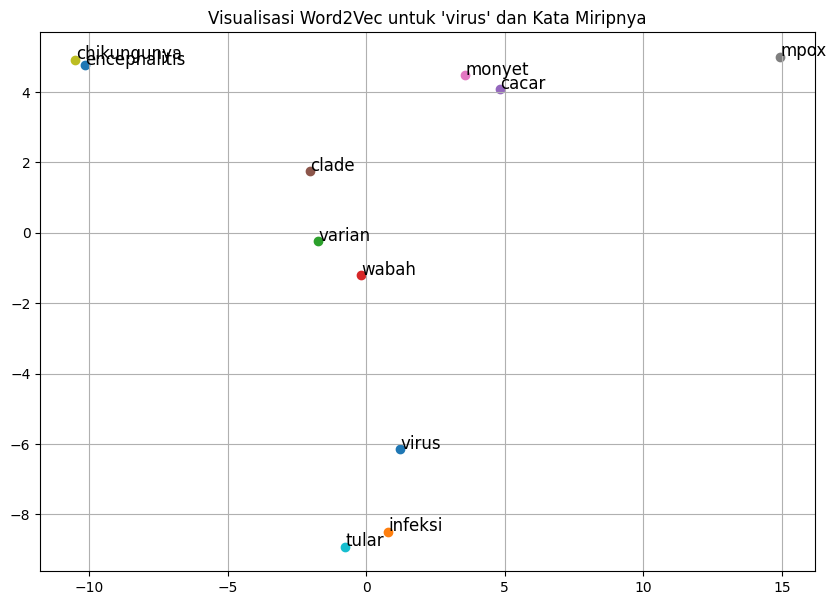

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Ambil kata target dan kata-kata yang mirip
if test_word in loaded_model.wv:
    similar_words = loaded_model.wv.most_similar(test_word, topn=10)
    words = [test_word] + [word for word, _ in similar_words]
    vectors = [loaded_model.wv[word] for word in words]

    # Reduksi dimensi dengan PCA
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(10, 7))
    for i, word in enumerate(words):
        x, y = reduced_vectors[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)

    plt.title(f"Visualisasi Word2Vec untuk '{test_word}' dan Kata Miripnya")
    plt.grid(True)
    plt.show()
else:
    print(f"Kata '{test_word}' tidak ditemukan dalam model.")


In [6]:
# Menggunakan Elbow Method untuk menentukan jumlah cluster optimal
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
from typing import Tuple, List, Optional

# Suppress warnings untuk output yang lebih bersih
warnings.filterwarnings('ignore', category=FutureWarning)

def find_optimal_clusters(vectors: np.ndarray, max_k: int = 10, 
                         min_k: int = 2, random_state: int = 42) -> Tuple[List[int], List[float], List[float]]:
    """
    Menentukan jumlah cluster optimal menggunakan Elbow Method dan Silhouette Score.
    
    Args:
        vectors: Array vektor untuk clustering
        max_k: Maksimum jumlah cluster yang akan dicoba
        min_k: Minimum jumlah cluster (default 2)
        random_state: Seed untuk reproducibility
    
    Returns:
        Tuple berisi (k_range, inertia_values, silhouette_scores)
    """
    if len(vectors) < max_k:
        max_k = len(vectors) - 1
        print(f"Warning: max_k disesuaikan menjadi {max_k} karena jumlah data terbatas")
    
    k_range = range(min_k, max_k + 1)
    inertia_values = []
    silhouette_scores = []
    
    print(f"Menghitung inertia dan silhouette score untuk k = {min_k} hingga {max_k}...")
    
    for k in k_range:
        # Inisialisasi KMeans dengan parameter yang lebih robust
        kmeans = KMeans(
            n_clusters=k, 
            n_init=10,  # Lebih banyak inisialisasi untuk hasil yang stabil
            max_iter=300,
            random_state=random_state,
            algorithm='lloyd'  # Algoritma yang lebih stabil
        )
        
        # Fit model
        cluster_labels = kmeans.fit_predict(vectors)
        
        # Simpan inertia dan silhouette score
        inertia_values.append(kmeans.inertia_)
        sil_score = silhouette_score(vectors, cluster_labels)
        silhouette_scores.append(sil_score)
        
        print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")
    
    return list(k_range), inertia_values, silhouette_scores

def calculate_elbow_point(k_range: List[int], inertia_values: List[float]) -> Optional[int]:
    """
    Menghitung elbow point menggunakan metode second derivative atau manual detection.
    """
    try:
        from kneed import KneeLocator
        kl = KneeLocator(k_range, inertia_values, curve='convex', direction='decreasing')
        return kl.elbow
    except ImportError:
        # Fallback: gunakan metode second derivative sederhana
        if len(inertia_values) < 3:
            return None
        
        # Hitung rate of change
        first_diff = np.diff(inertia_values)
        second_diff = np.diff(first_diff)
        
        # Cari titik dengan perubahan terbesar dalam second derivative
        elbow_idx = np.argmax(second_diff) + 2  # +2 karena diff mengurangi panjang array
        if elbow_idx < len(k_range):
            return k_range[elbow_idx]
        return None

def plot_elbow_analysis(k_range: List[int], inertia_values: List[float], 
                       silhouette_scores: List[float], elbow_k: Optional[int] = None):
    """
    Membuat visualisasi lengkap untuk analisis elbow method.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Elbow Curve
    ax1.plot(k_range, inertia_values, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
    ax1.set_title('Elbow Method: Inertia vs Jumlah Cluster', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Jumlah Cluster (k)', fontsize=12)
    ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xticks(k_range)
    
    # Tandai elbow point jika ada
    if elbow_k and elbow_k in k_range:
        elbow_idx = k_range.index(elbow_k)
        ax1.axvline(x=elbow_k, color='red', linestyle='--', linewidth=2, 
                   label=f'Elbow Point (k={elbow_k})')
        ax1.scatter(elbow_k, inertia_values[elbow_idx], color='red', s=100, zorder=5)
        ax1.legend()
    
    # Plot 2: Silhouette Score
    ax2.plot(k_range, silhouette_scores, marker='s', linestyle='-', color='green', 
             linewidth=2, markersize=8)
    ax2.set_title('Silhouette Score vs Jumlah Cluster', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Jumlah Cluster (k)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xticks(k_range)
    
    # Tandai k dengan silhouette score tertinggi
    best_sil_k = k_range[np.argmax(silhouette_scores)]
    best_sil_score = max(silhouette_scores)
    ax2.axvline(x=best_sil_k, color='orange', linestyle='--', linewidth=2, 
               label=f'Best Silhouette (k={best_sil_k})')
    ax2.scatter(best_sil_k, best_sil_score, color='orange', s=100, zorder=5)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_sil_k

def recommend_optimal_k(k_range: List[int], inertia_values: List[float], 
                       silhouette_scores: List[float], elbow_k: Optional[int]) -> int:
    """
    Memberikan rekomendasi k optimal berdasarkan multiple metrics.
    """
    best_sil_k = k_range[np.argmax(silhouette_scores)]
    
    print("\n" + "="*50)
    print("ANALISIS JUMLAH CLUSTER OPTIMAL")
    print("="*50)
    
    if elbow_k:
        print(f"📊 Elbow Method menyarankan: k = {elbow_k}")
    else:
        print("📊 Elbow point tidak terdeteksi secara otomatis")
    
    print(f"🎯 Silhouette Score tertinggi pada: k = {best_sil_k} (score: {max(silhouette_scores):.3f})")
    
    # Pertimbangan tambahan
    if elbow_k and abs(elbow_k - best_sil_k) <= 1:
        recommended_k = elbow_k
        print(f"✅ REKOMENDASI: k = {recommended_k} (konsisten antara kedua metrik)")
    elif elbow_k:
        recommended_k = elbow_k
        print(f"✅ REKOMENDASI: k = {recommended_k} (prioritas pada elbow method)")
    else:
        recommended_k = best_sil_k
        print(f"✅ REKOMENDASI: k = {recommended_k} (berdasarkan silhouette score)")
    
    print("="*50)
    return recommended_k

# IMPLEMENTASI UTAMA
def analyze_optimal_clusters(vectors: np.ndarray, max_k: int = 10) -> int:
    """
    Fungsi utama untuk analisis lengkap penentuan cluster optimal.
    """
    print("🔍 Memulai analisis penentuan jumlah cluster optimal...")
    print(f"📈 Data: {len(vectors)} vektor dengan dimensi {vectors.shape[1]}")
    
    # Hitung metrik untuk berbagai k
    k_range, inertia_values, silhouette_scores = find_optimal_clusters(vectors, max_k)
    
    # Tentukan elbow point
    elbow_k = calculate_elbow_point(k_range, inertia_values)
    
    # Visualisasi
    best_sil_k = plot_elbow_analysis(k_range, inertia_values, silhouette_scores, elbow_k)
    
    # Rekomendasi final
    recommended_k = recommend_optimal_k(k_range, inertia_values, silhouette_scores, elbow_k)
    
    return recommended_k

# PENGGUNAAN:
# Pastikan 'loaded_model' sudah didefinisikan sebelumnya
# vectors = loaded_model.wv.vectors
# optimal_k = analyze_optimal_clusters(vectors, max_k=10)

In [7]:
# Ambil vektor dari Word2Vec model
vectors = loaded_model.wv.vectors

# Jalankan analisis lengkap
optimal_k = analyze_optimal_clusters(vectors, max_k=10)

# Gunakan hasil untuk clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(vectors)

🔍 Memulai analisis penentuan jumlah cluster optimal...
📈 Data: 91064 vektor dengan dimensi 300
Menghitung inertia dan silhouette score untuk k = 2 hingga 10...
k=2: Inertia=4019321.75, Silhouette=0.655


KeyboardInterrupt: 